# EWX Forecasting Rules

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#import workalender
import json
import pprint
import os
pp = pprint.PrettyPrinter(1)
basepath = os.getcwd()
json_files = os.path.join(basepath, 'json')
csv_files = os.path.join(basepath, 'csv')

mypath = "C:\\Users\\wb5888\\Documents\\IDR Data\\NEPOOL\\CLP"
basepath = mypath

print('working in {}'.format(basepath))

working in C:\Users\wb5888\Documents\IDR Data\NEPOOL\CLP


## Functions to Use

In [45]:
##### import functions ####

def sortdir(filepath, num):
    os.chdir(filepath)
    files = np.array(os.listdir())
    time = []
    for file in files:
        try:
            sys_time = round(os.path.getmtime(filepath + "\\" + file))
        except:
            sys_time = round(os.path.getmtime(filepath + "/" + file))
        
        time.append(dt.datetime.fromtimestamp(sys_time))

    time = np.array(time)
    lab = ['files']
    filedf = pd.DataFrame(files, columns = lab)

    filedf['time'] = time
    filedf = filedf.sort_values(by = 'time', axis = 0, ascending = False).reset_index(drop = True)

    print("files found in dir: ", filepath)
    print(filedf.head(num))
    return(filedf.head(num))

def parse_engie(payload):

    with open(payload) as raw:
        idr_engie = json.load(raw)

    trnx = idr_engie['transactioninfo']
    acct = idr_engie['account']

    print('saving data files')
    try:
        ts_sca_data = acct['timeseriesdatascalar']
        sca_payload = pd.DataFrame.from_dict(ts_sca_data).iloc[:,1:]
        sca_payload['start'] = pd.to_datetime(sca_payload.start)
        sca_payload['stop'] = pd.to_datetime(sca_payload.stop)
        sca_payload.v = [float(val) for val in sca_payload.v]
    
    except:
        sca_payload = None
    
    ts_idr_data = acct['timeseriesdataidr']
    n = len(ts_idr_data)

    ch = ts_idr_data[0]['channel']
    hb = ts_idr_data[0]['heartbeat']
    print('found', hb, 'heartbeats')
    idr_payload = pd.DataFrame.from_dict(ts_idr_data[0]['reads'])
    idr_payload.v = [float(val) for val in idr_payload.v]
    
    idr_payload.t = pd.to_datetime(idr_payload.t)
    idr_payload = idr_payload.set_index(pd.DatetimeIndex(idr_payload.t))
    idr_payload = idr_payload.drop('t', axis = 1)
           
    print('found {} reads, creating dataset.'.format(n))

        
    for i in range(1,n):
        reads = ts_idr_data[i]['reads']
        temp = pd.DataFrame.from_dict(reads)
        
        temp.v = [float(val) for val in temp.v]
    
        temp.t = pd.to_datetime(temp.t)
        temp = temp.set_index(pd.DatetimeIndex(temp.t))
        temp = temp.drop('t', axis = 1)
            
            #tempname = "_".join([filename.split('.')[0], 'year', str(i), '.csv'])
            #print('writing {}'.format(tempname))
            
            #temp.to_csv(tempname, header = True, index = False)
        idr_payload = pd.concat([idr_payload, temp], axis = 0)
        
    print(idr_payload.head())
    print('...')
    print(idr_payload.tail())
    

    print('saving meterid and cap tags')
    meterid = '_'.join([acct['market'], acct['discocode'], acct['accountnumber']])
    
    try:
        caps = acct['captag'][0]

        caps_df = pd.DataFrame.from_records(caps, index = [0]).iloc[:,2:]
        caps_df['start'] = pd.to_datetime(caps_df['start'])
        caps_df['stop'] = pd.to_datetime(caps_df['stop'])
        caps_df.v = [float(val) for val in caps_df.v]
    
    except:
        caps_df = None

    return(idr_payload, int(hb), sca_payload, caps_df, meterid)


def parse_ewx(file):
    
    with open(file) as raw:
        print("loading json...")
        data = json.load(raw) #raw json file
        
    acct = data['account'] #get account data
    ch3 = acct['timeseriesdataidr'] #dictionary of acct attributes
    n = len(ch3)
        
    reads = ch3[0]['reads']
    master_df = pd.DataFrame.from_dict(reads)
    master_df.t = pd.to_datetime(master_df.t)
        
    print('found {} reads, creating dataset.'.format(n))
        
    for i in range(1,n):
        reads = ch3[i]['reads']
        temp = pd.DataFrame.from_dict(reads)
        temp.t = pd.to_datetime(temp.t)
        master_df = pd.concat([master_df, temp]).reset_index(drop = True)
    
    print("saving to dataframe...")
    
    master_df = master_df.set_index(master_df.t)
    master_df = master_df.drop('t', axis = 1)
    
    return(master_df)

#### validation functions ####

def periodic_zero(idr, margin, threshold):
    
    tmp = idr.copy()

    tmp['d'] = [time.dayofweek for time in tmp.index]
    tmp['h'] = [time.hour for time in tmp.index]

    #bool if value less than margin
    zeroreadmask = tmp['v'] <= margin #margin = .01
    
    #group zero reads by weekday and hour
    day_hr = list(zip(tmp.index.dayofweek, tmp.index.hour))
    zero_read_group = zeroreadmask.groupby([tmp.index.dayofweek, tmp.index.hour])

    #find proportion of zero reads
    weekly_periodic_reads = pd.DataFrame(zero_read_group.sum().astype(int) / zero_read_group.count())
    
    weekly_periodic_reads.index.names = ['d', 'h']
    weekly_periodic_reads.columns = ['pz']
    
    zeros = pd.merge(tmp, weekly_periodic_reads, how = 'left', right_index = True, left_on = ['d', 'h'])
    
    low_reads = [(zero > 0 and zero < threshold) for zero in zeros.pz]
    zeros['lr'] = low_reads
    
    return(zeros)

def interval_gap_check(tmp2):
    val_diff = tmp2.v.diff().fillna(value = 0)
    time_diff = tmp2.index.to_series().diff()
    time_diff = time_diff.dt.seconds.div(3600, fill_value = 3600)

    tmp2['vd'] = val_diff
    tmp2['td'] = time_diff
    
    #check interval gaps
    gap_after_index = [(float(td) != 1) for td in time_diff]
    tmp2['gap'] = gap_after_index
    
    return(tmp2)


def variance_validation(tmp2, time_window, centered, n_sd):

    tmp2['rm'] = tmp2['v'].rolling(window = time_window, min_periods = 1, center = centered).mean()
    tmp2['mc'] = tmp2.v - tmp2.rm

    tmp2['crm'] = tmp2['mc'].rolling(window = time_window, min_periods = 10, center = centered).mean()
    tmp2['crsd'] = tmp2['mc'].rolling(window = time_window, min_periods = 10, center = centered).std()

    tmp2['var'] = (tmp2['mc'] - tmp2['crm'])/tmp2['crm']

    tmp2['spike'] = tmp2['mc'] > (tmp2['crm'] + (n_sd + 1) * tmp2['crsd'])
    tmp2['dip'] = tmp2['mc'] < (tmp2['crm'] - n_sd * tmp2['crsd'])
    
    return(tmp2)


def dst_check(tmp2):
    beg_for = dt.datetime.strptime('03/08/2018', '%m/%d/%Y')
    end_for = dt.datetime.strptime('03/14/2018', '%m/%d/%Y')
    beg_back = dt.datetime.strptime('11/01/2018', '%m/%d/%Y')
    end_back = dt.datetime.strptime('11/07/2018', '%m/%d/%Y')
    
    date_check = [(((date >= beg_for) and (date <= end_for)) or ((date >= beg_back) and (date <= end_back))) for date in tmp2.index]
    
    time_check = [diff != 1 for diff in tmp2.td]
    
    dst = [a and b for a, b in zip(date_check, time_check)]
    tmp2['dst'] = dst
    
    return(tmp2)

##fix bad time interval (15 min, etc)
def fix_interval(data):
    
    times = data.index.to_series()
    times = pd.to_datetime(times)

    minute = [int(v.minute) for v in times]
    data['min'] = minute

    date = list(zip(data.d, data.h))
    data['date_zip'] = date
    
    bad_time = data.loc[data.td != 1,:]
    good_time = data.loc[data.td == 1,:]
    
    bt_group = bad_time.groupby([bad_time.date_zip])

    final = bad_time.loc[bad_time['min'] == 0,:]
    adj_v = [4*val for val in final.v]

    final['v'] = adj_v

    final_out = pd.concat([good_time, final], axis = 0)
    final_out.sort_index(inplace = True)

    return(final_out)

#### estimation functions ####

def dst_fix(tmp2):
    for i, index in enumerate(tmp2.index):
        
        if (tmp2.dst[index] == True) and (tmp2.td[index] == 0):
            tmp2.drop(label = index, axis = 0)
            
        elif (tmp2.dst[index] == True) and (tmp2.td[index] == 2):
            add_time = index + dt.timedelta(hours = 1)
            tmp2.index.insert((i+1), add_time)
        
        return(tmp2)
    
def interp(vals, flag):
    need_interp = vals.copy()
    for j, error in enumerate(flag):
        if error:
            need_interp[j] = np.nan
    need_interp.columns = 'interp'
    return(need_interp)

def gen_year(data, num_days):
    most_recent = max(data.index)
    year_back = most_recent - dt.timedelta(days = num_days, hours = most_recent.hour)
    oldest = min(data.index)
    gap = oldest - year_back
    gap_hr = int(divmod(gap.total_seconds(), 3600)[0])
    
    year_data = data[year_back:most_recent]
    agg = year_data.groupby(['mon', 'd', 'h'])['lin'].median()
    year_forward = most_recent + dt.timedelta(days = 364, hours = 24 - most_recent.hour)
    delta = year_forward - most_recent
    delta_hr = int(divmod(delta.total_seconds(), 3600)[0])

    next_year = []
    for i in range(1, delta_hr):
        next_year.append(most_recent + dt.timedelta(hours = i))
        

    month = [a.month for a in next_year]
    day = [a.dayofweek for a in next_year]
    hour = [a.hour for a in next_year]

    forecast = pd.DataFrame({'t':next_year, 'mon':month, 'd':day, 'h':hour, 'date_zip':list(zip(month, day, hour))})
    forecast.set_index('t', drop = True, inplace = True)
    forecast['lin'] = agg[forecast.date_zip].reset_index(drop = True).values.tolist()
    return(forecast)

def timeshift(data, until):
    year = 0
    until += 1
    recent = max(data.index)
    beg_yr = dt.datetime(month = 1, day = 1, hour = 0, minute = 0, year = recent.year)
    early = data[beg_yr:recent]
    
    master = gen_year(data, 364)
    master = pd.concat([early, master], axis = 0)
    print('forecasted year {} of {} with {} reads.'.format(year, until, len(master.lin)))
    year += 1
    
    while year <= until:
        if (year % 6 == 0 and year > 0):
            num_days = 371
        else:
            num_days = 364
        
        forecast = gen_year(master, num_days)
        master = pd.concat([master, forecast], axis = 0)
        print('forecasted year {} of {} with {} reads.'.format(year, until, len(forecast.lin)))
        year += 1
    
    #last_date = max(master.index)
    #end_yr = dt.datetime(month = 12, day = 31, hour = 23, year = last_date.year)
    #finish = (end_yr - last_date).days
    #final = gen_year(master, finish)
    #master = pd.concat([master, final], axis = 0)
    
    master = master['lin']
    return(master)

In [2]:
def forecast_main(json_file, read, write):
    
    print('parsing data files...')
    #parse json file
    if 'json' in json_file:
        name = json_file.split('_')[1:]
        filename = '_'.join(name)
        filename = filename.replace('json', 'csv')
        print('using filename {}.'.format(filename))
    
    else:
        filename = json_file
        print('using filename {}.'.format(filename))
    
    if read is not None and type(json_file) == str:
        os.chdir(read)
        try:
            idr, hb, sca, caps, meter = parse_engie(json_file)
            
        except:
            idr = pd.read_csv(filename)
            
        idr = idr.loc[pd.notnull(idr.index),:]
        print('read {} from {}.'.format(filename, read))
    
    else:
        idr = json_file
    
    print('running data validations...')
    #check for nonperiodic zeros
    tmp2 = periodic_zero(idr, .01, 1)
    print('...')
    
    tmp2['mon'] = [a.month for a in tmp2.index]
 
    #get value & time differences
    tmp2 = interval_gap_check(tmp2)
    print('...')
    
    #check spikes & dips
    #time_window = int(60*24*3600/hb)
    time_window = int(30*24)
    centered = True
    n_sd = 2

    tmp2 = variance_validation(tmp2, time_window, centered, 2)
    print('...')
    
    #check for dst (missing hour 3/8-3/14 and extra value 11/1-11/7)
    tmp2 = dst_check(tmp2)
    print('...')
    
    #fix nonhour interval reads
    tmp2 = fix_interval(tmp2)
    print('...')
    
    print('usage validated.')
    
    print('running usage estimation flags...')
    data_filter = [a or b or c or d for a, b, c, d in zip(tmp2.lr, tmp2.gap, tmp2.spike, tmp2.dip)]
    tmp2['err'] = data_filter
    
    tmp2['interp'] = interp(tmp2.v, tmp2.err)
    
    linear = tmp2.interp.interpolate(method = 'linear', axis = 0, in_place = False, limit_direction = 'forward')
    tmp2['lin'] = linear
    
    #final validated data
    final = tmp2.copy()
    
    
    if write is not None:
        print('writing validated usage file to .csv...')
        os.chdir(write)
        final.to_csv(filename, header = True, index = True)
        print('wrote {} to {}.'.format(filename, write))
        
        
    print('forecasting...')
    print('')
    forecast = timeshift(final, 10)
    print('...')
    
    print('generated forecast.')
    print(forecast.head())
    print('...')
    print(forecast.tail())
    
    if write is not None:
        print('writing validated usage file to .csv...')
        os.chdir(write)
        final.to_csv(filename, header = True, index = True)
        print('wrote {} to {}.'.format(filename, write))
        print('writing forecasts to .csv...')
        name = filename.split('.')[0]
        ts_name = '_'.join([name, 'timeshift'])
        ts_name = '.'.join([ts_name, 'csv'])
        forecast.to_csv(ts_name)
        print('wrote {} to {}.'.format(ts_name, write))
        
    
    return(forecast)
    

## Run Main Forecasting 

### To Do

1. Fill in gaps in missing time values (if gap = true)
2. Interpolate usage values for missing time values (if gap or lr = true)
3. Fill usage gaps with likeday estimation
4. More validations :)

In [6]:
filedf = sortdir(json_files, 10)
engie_json = filedf.files[2]
print(' ')
print('using file:', engie_json)

files found in dir:  /Volumes/USB30FD/LA-tools/EWX_Forecast/json
                                              files                time
0  20190610104203499000_NEPOOL_MECO_6276568002.json 2019-06-11 10:06:04
1  20190610104100770000_NEPOOL_MECO_0061849009.json 2019-06-11 10:05:20
2     engie_NEPOOL_WMECO_54024602039_024741000.json 2019-06-03 07:49:32
3     engie_NEPOOL_WMECO_54311202097_965441008.json 2019-06-03 07:49:32
4       ewx_NEPOOL_WMECO_54024602039_024741000.json 2019-06-03 07:49:32
5       ewx_NEPOOL_WMECO_54311202097_965441008.json 2019-06-03 07:49:32
 
using file: engie_NEPOOL_WMECO_54024602039_024741000.json


In [51]:
os.chdir(json_files)
clean_idr = forecast_main(engie_json, json_files, csv_files)

parsing data files...
using filename NEPOOL_WMECO_54024602039_024741000.csv.
saving data files
found 3600 heartbeats
found 1 reads, creating dataset.
                           v
t                           
2018-11-01 00:00:00  779.220
2018-11-01 01:00:00  739.260
2018-11-01 02:00:00  772.416
2018-11-01 03:00:00  767.340
2018-11-01 04:00:00  765.504
...
                            v
t                            
2019-05-20 20:00:00  1135.728
2019-05-20 21:00:00  1084.212
2019-05-20 22:00:00  1116.828
2019-05-20 23:00:00  1102.248
NaT                       NaN
saving meterid and cap tags
read NEPOOL_WMECO_54024602039_024741000.csv from /Volumes/USB30FD/LA-tools/EWX_Forecast/json.
running data validations...
...
...
...
...
...
usage validated.
running usage estimation flags...
writing validated usage file to .csv...
wrote NEPOOL_WMECO_54024602039_024741000.csv to /Volumes/USB30FD/LA-tools/EWX_Forecast/csv.
forecasting...
forecasted year 0 of 11 with 12096 reads.
forecasted year 1 of 11

In [49]:
clean_idr.head()

2019-01-01 00:00:00    537.084
2019-01-01 01:00:00    536.652
2019-01-01 02:00:00    536.760
2019-01-01 03:00:00    529.524
2019-01-01 04:00:00    524.124
Name: lin, dtype: float64

In [70]:
hb = clean_idr.index.to_series().diff()
a = np.mean(hb)
a.total_seconds()

3600.0

In [8]:
cols = clean_idr.columns

key = ['usage value', 'weekday', 'hour', 'periodic zeros', 'low read', 'month', 'value difference', 'time difference', \
 'flag for gaps (td =/= 1)', 'rolling mean', 'mean centered usage', 'centered rolling mean', 'centered rolling std dev',\
 'variance', 'flags spikes', 'flags dips', 'flags dst', 'flags errors (lr, pz, gap, spike, dip, dst)', 'interpolated values',\
 'minutes (for nonhourly data)', 'day and hour combined']

col_key = pd.DataFrame({'key':key})
col_key.set_index(cols, inplace = True, drop = True)
col_key


,key
v,usage value
d,weekday
h,hour
pz,periodic zeros
lr,low read
mon,month
vd,value difference
td,time difference
gap,flag for gaps (td =/= 1)
rm,rolling mean


In [9]:
clean_idr.columns

#final_out.to_csv('year_forecast2.csv')

Index(['v', 'd', 'h', 'pz', 'lr', 'mon', 'vd', 'td', 'gap', 'rm', 'mc', 'crm',
       'crsd', 'var', 'spike', 'dip', 'dst', 'err', 'interp', 'min',
       'date_zip'],
      dtype='object')

## Test main_forecast

In [173]:
#parse json file
os.chdir(json_files)
idr, hb, sca, caps, meter = parse_engie(engie_json)
idr = idr.loc[pd.notnull(idr.index),:]
    
#check for nonperiodic zeros
tmp2 = periodic_zero(idr, .01, 1)

tmp2['mon'] = [a.month for a in tmp2.index]

#get value & time differences
tmp2 = interval_gap_check(tmp2)

#check spikes & dips
time_window = int(60*24*3600/hb)
centered = True
n_sd = 2

tmp2 = variance_validation(tmp2, time_window, centered, 2)

#check for dst errors
tmp2 = dst_check(tmp2)

data_filter = [a or b or c or d for a, b, c, d in zip(tmp2.lr, tmp2.gap, tmp2.spike, tmp2.dip)]
tmp2['err'] = data_filter

#flag for interpolation, linear interpolate
tmp2['interp'] = interp(tmp2.v, tmp2.err)
linear = tmp2.interp.interpolate(method = 'linear', axis = 0, in_place = False, limit_direction = 'forward')
tmp2['lin'] = linear

#fix nonhour interval reads
tmp2 = fix_interval(tmp2)

final = tmp2.copy()

print('forecasting...')
forecast = timeshift(final, 10)

saving data files
found 3600 heartbeats
found 1 reads, creating dataset.
                           v
t                           
2018-11-01 00:00:00  779.220
2018-11-01 01:00:00  739.260
2018-11-01 02:00:00  772.416
2018-11-01 03:00:00  767.340
2018-11-01 04:00:00  765.504
...
                            v
t                            
2019-05-20 20:00:00  1135.728
2019-05-20 21:00:00  1084.212
2019-05-20 22:00:00  1116.828
2019-05-20 23:00:00  1102.248
NaT                       NaN
saving meterid and cap tags
forecasting...
forecasted year 0 of 10 with 8736 reads.
forecasted year 1 of 10 with 8736 reads.
forecasted year 2 of 10 with 8736 reads.
forecasted year 3 of 10 with 8736 reads.
forecasted year 4 of 10 with 8736 reads.
forecasted year 5 of 10 with 8736 reads.
forecasted year 6 of 10 with 8736 reads.
forecasted year 7 of 10 with 8736 reads.
forecasted year 8 of 10 with 8736 reads.
forecasted year 9 of 10 with 8736 reads.


In [230]:
tmp2.head()

,v,d,h,pz,lr,mon,vd,td,gap,rm,...,crsd,var,spike,dip,dst,err,interp,lin,min,date_zip
2018-11-01 00:00:00,779.220,3,0,0.0,False,11,0.000,1.0,False,665.010450,...,135.736495,-4.419808,False,False,False,False,779.220,779.220,0,"(3, 0)"
2018-11-01 01:00:00,739.260,3,1,0.0,False,11,-39.960,1.0,False,665.096205,...,135.659762,-3.226126,False,False,False,False,739.260,739.260,0,"(3, 1)"
2018-11-01 02:00:00,772.416,3,2,0.0,False,11,33.156,1.0,False,665.181125,...,135.582944,-4.226603,False,False,False,False,772.416,772.416,0,"(3, 2)"
2018-11-01 03:00:00,767.340,3,3,0.0,False,11,-5.076,1.0,False,665.262373,...,135.504838,-4.078559,False,False,False,False,767.340,767.340,0,"(3, 3)"
2018-11-01 04:00:00,765.504,3,4,0.0,False,11,-1.836,1.0,False,665.358315,...,135.433631,-4.028681,False,False,False,False,765.504,765.504,0,"(3, 4)"


<IPython.core.display.Javascript object>


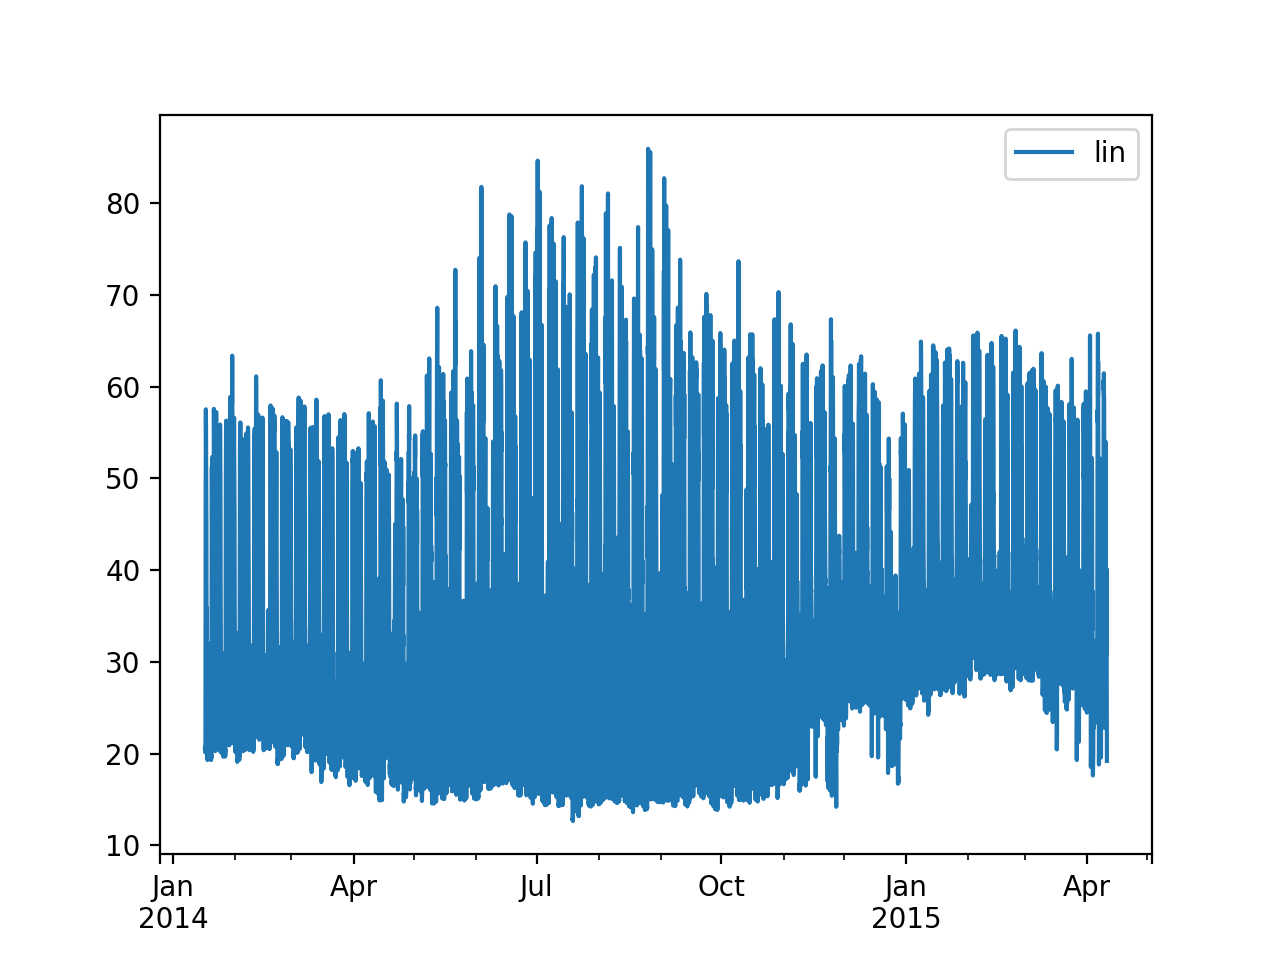

In [136]:
tmp2.plot(y = 'lin')

In [253]:
most_recent = max(sca.start)
last_yr = most_recent - dt.timedelta(days = 364)

recent_sca = sca[sca.stop > last_yr]
recent_sca

,start,stop,v
0,2019-04-10,2019-05-12 23:59:59,756720.0
1,2019-03-12,2019-04-09 23:59:59,624240.0
2,2019-02-11,2019-03-11 23:59:59,581760.0
3,2019-01-11,2019-02-10 23:59:59,694080.0
4,2018-12-31,2019-01-10 23:59:59,188526.0
5,2018-11-08,2018-12-30 23:59:59,887153.0
6,2018-10-11,2018-11-07 23:59:59,481680.0
7,2018-09-12,2018-10-10 23:59:59,542880.0
8,2018-08-13,2018-09-11 23:59:59,576720.0
9,2018-07-12,2018-08-12 23:59:59,636480.0


## Timeshift

In [252]:
data = final.copy()
num_days = 364

In [254]:
data = final.copy()
most_recent = max(data.index)
year_back = most_recent - dt.timedelta(days = num_days, hours = most_recent.hour)

oldest = min(data.index)
gap = oldest - year_back
gap_hr = int(divmod(gap.total_seconds(), 3600)[0])

if year_back < oldest:
    
    fill_year = []
    for j in range(0, gap_hr):
        fill_year.append(year_back + dt.timedelta(hours = j))
        
    fill_year = pd.DataFrame({'t':fill_year})
    fill_year.t = pd.to_datetime(fill_year.t)
    fill_year.set_index('t', drop = True, inplace = True)
    
    fill_year['d'] = [a.dayofweek for a in fill_year.index]
    fill_year['mon'] = [a.month for a in fill_year.index]
    fill_year['h'] = [a.hour for a in fill_year.index]
    fill_year['min'] = [a.minute for a in fill_year.index]
    fill_year['date_zip'] = list(zip(fill_year.d, fill_year.h))
    
    buildout = pd.concat([fill_year, data], axis = 0)
    year_data = buildout.copy()

else: 
    
    year_data = data[year_back:most_recent]    
    
print(buildout.head())
print(buildout.tail())

agg = year_data.groupby(['mon', 'd', 'h'])['v'].median()
year_forward = most_recent + dt.timedelta(days = 364, hours = 24 - most_recent.hour)
delta = year_forward - most_recent
delta_hr = int(divmod(delta.total_seconds(), 3600)[0])

next_year = []
for i in range(1, delta_hr):
    next_year.append(most_recent + dt.timedelta(hours = i))

month = [a.month for a in next_year]
day = [a.dayofweek for a in next_year]
hour = [a.hour for a in next_year]

forecast = pd.DataFrame({'t':next_year, 'mon':month, 'd':day, 'h':hour, 'date_zip':list(zip(day, hour))})
forecast.set_index('t', drop = True, inplace = True)
forecast['v'] = agg[forecast.date_zip].reset_index(drop = True).values.tolist()


                     crm  crsd  d date_zip  dip  dst  err  gap  h  interp ...  \
2018-05-21 00:00:00  NaN   NaN  0   (0, 0)  NaN  NaN  NaN  NaN  0     NaN ...   
2018-05-21 01:00:00  NaN   NaN  0   (0, 1)  NaN  NaN  NaN  NaN  1     NaN ...   
2018-05-21 02:00:00  NaN   NaN  0   (0, 2)  NaN  NaN  NaN  NaN  2     NaN ...   
2018-05-21 03:00:00  NaN   NaN  0   (0, 3)  NaN  NaN  NaN  NaN  3     NaN ...   
2018-05-21 04:00:00  NaN   NaN  0   (0, 4)  NaN  NaN  NaN  NaN  4     NaN ...   

                     mc min  mon  pz  rm  spike  td   v  var  vd  
2018-05-21 00:00:00 NaN   0    5 NaN NaN    NaN NaN NaN  NaN NaN  
2018-05-21 01:00:00 NaN   0    5 NaN NaN    NaN NaN NaN  NaN NaN  
2018-05-21 02:00:00 NaN   0    5 NaN NaN    NaN NaN NaN  NaN NaN  
2018-05-21 03:00:00 NaN   0    5 NaN NaN    NaN NaN NaN  NaN NaN  
2018-05-21 04:00:00 NaN   0    5 NaN NaN    NaN NaN NaN  NaN NaN  

[5 rows x 22 columns]
                           crm        crsd  d date_zip    dip    dst    err  \
2019-05-2

In [143]:
test = timeshift(tmp2, 10)

forecasted year 0 of 10 with 8736 reads.
forecasted year 1 of 10 with 8736 reads.
forecasted year 2 of 10 with 8736 reads.
forecasted year 3 of 10 with 8736 reads.
forecasted year 4 of 10 with 8736 reads.
forecasted year 5 of 10 with 8736 reads.
forecasted year 6 of 10 with 8736 reads.
forecasted year 7 of 10 with 8736 reads.
forecasted year 8 of 10 with 8736 reads.
forecasted year 9 of 10 with 8736 reads.


<IPython.core.display.Javascript object>


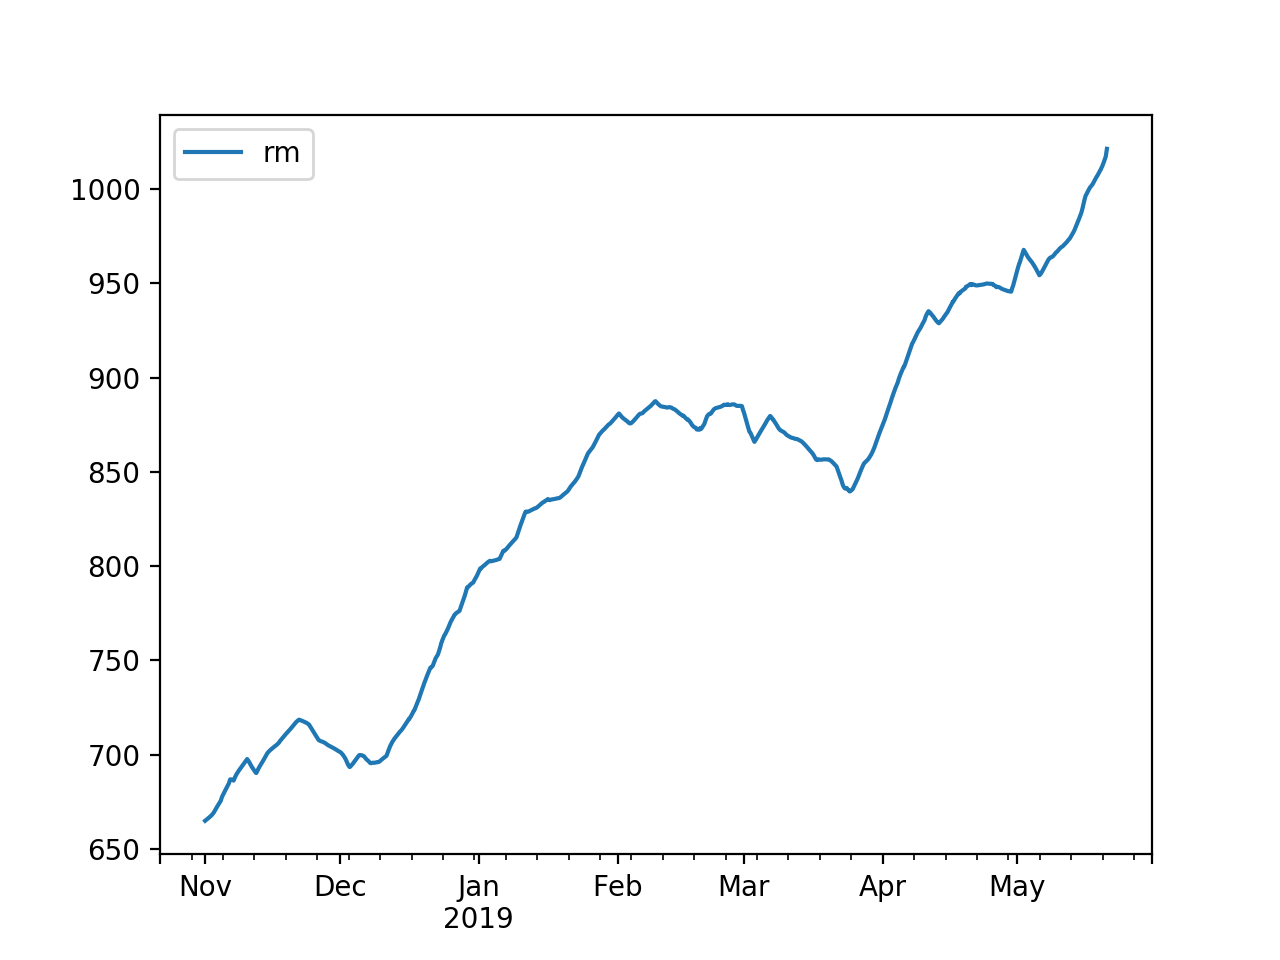

In [255]:
final.plot(y = 'rm')

In [134]:
test.to_csv('test_forecast.csv')

In [264]:
gen_year(final, 364)

AttributeError: 'list' object has no attribute 'month'

## Build out IDR from Scalar

In [256]:
group_means = tmp2.groupby(['d', 'h'])['v'].median()
group_crsd = tmp2.groupby(['d', 'h'])['crsd'].median()
group_crm = tmp2.groupby(['d', 'h'])['crm'].median()

fill_year['v'] = group_means[fill_year.date_zip].reset_index(drop = True).values.tolist()
fill_year['crsd'] = group_crsd[fill_year.date_zip].reset_index(drop = True).values.tolist()
fill_year['crm'] = group_crsd[fill_year.date_zip].reset_index(drop = True).values.tolist()
#use = [a * b + c for a, b, c in zip(fill_year.crm, fill_year.crsd, fill_year.v)]
#makeup_df['v'] = use                                    

tmp2_sub = tmp2[['v', 'mon']]
fill_year_sub = fill_year[['v', 'mon']]

master = pd.DataFrame(pd.concat([fill_year_sub, tmp2_sub]))

In [257]:
most_recent = max(sca.start)
last_yr = most_recent - dt.timedelta(days = 364)

recent_sca = sca[sca.stop > last_yr]
recent_sca

crsd = tmp2.groupby(['mon'])['crsd'].mean()
crm = tmp2.groupby(['mon'])['crm'].mean()
mean = tmp2.groupby(['mon'])['v'].mean()

monthly = pd.DataFrame({'mean':mean, 'crm': crm, 'crsd':crsd})

sca_days = [(b - a).days for a, b in zip(recent_sca.start, recent_sca.stop)]
month = recent_sca.stop.dt.month - 1
month[month==0] = 12
avg_daily = [round(b/a,2) for a, b in zip(sca_days, recent_sca.v)]

scalar_stats = pd.DataFrame({'sca':recent_sca.v, 'mon':month, 'days':sca_days, 'avg_daily':avg_daily})
scalar_stats.set_index('mon', drop = True, inplace = True)

monthly_stats = pd.concat([scalar_stats, monthly], axis = 1)
monthly_stats

,avg_daily,days,sca,crm,crsd,mean
mon,,,,,,
1,23136.00,30,694080.0,9.564258,130.558155,861.329323
2,20777.14,28,581760.0,12.255808,101.832371,899.209768
3,22294.29,28,624240.0,-18.876732,138.292415,849.089323
4,23647.50,32,756720.0,9.058797,183.667950,897.822150
5,27264.00,15,408960.0,17.232707,187.996635,1045.846575
6,20104.62,13,261360.0,NaN,NaN,NaN
7,20531.61,31,636480.0,NaN,NaN,NaN
8,19886.90,29,576720.0,NaN,NaN,NaN
9,19388.57,28,542880.0,NaN,NaN,NaN


## Scalar/IDR Checks

In [238]:
#start_date = min(recent_sca.start)
#recent_idr = master.v[master.index >= start_date]

scalar_idr_group_start = [makeup_df.index >= a for a in recent_sca.start]
scalar_idr_group_stop = [makeup_df.index <= b for b in recent_sca.stop]

monthly_idr = []
monthly_count = []

for i, a in enumerate(scalar_idr_group_start):
    b = scalar_idr_group_stop[i]
    bt = [c and d for c, d in zip(a, b)]
    monthly_use = sum(makeup_df.v[bt])
    monthly_count.append(sum(bt)/24)
    monthly_idr.append(round(monthly_use, 4))
    
daily_avg = [round(m/d, 2) for m, d in zip(monthly_idr, monthly_count)]
                       
idr_monthly_check = pd.DataFrame({'start':recent_sca.start, 'stop':recent_sca.stop, \
                                  'monthly':monthly_idr, 'days':monthly_count, 'daily avg':daily_avg})
print('monthly idr sums: ')
print(idr_monthly_check)
print('')
print('scalar data:')
print(recent_sca)

month = recent_sca.stop.dt.month - 1
month[month==0] = 12
sca_days = [(b - a).days for a, b in zip(recent_sca.start, recent_sca.stop)]
avg_daily = [round(b/a,2) for a, b in zip(sca_days, recenyt_sca.v)]

correction_factor = [b/a for a, b in zip(daily_avg, avg_daily)]

easy_sca = pd.DataFrame({'mon':month, 'v':recent_sca.v, 'days':sca_days, 'avg':daily_avg, 'cf':correction_factor})
#easy_sca.set_index('m', inplace = True)
easy_sca.cf[easy_sca.cf.isnull()] = 1
print(easy_sca)

master_cor = master.join(easy_sca.cf, on = 'mon')
master_cor.cf[master_cor.cf.isnull()] = 1
master_cor['v'] = [a*b for a, b in zip(master_cor.v, master_cor.cf)]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


monthly idr sums: 
    daily avg       days     monthly      start                stop
0         NaN   0.000000       0.000 2019-04-16 2019-05-15 23:59:59
1         NaN   0.000000       0.000 2019-03-15 2019-04-15 23:59:59
2         NaN   0.000000       0.000 2019-02-14 2019-03-14 23:59:59
3         NaN   0.000000       0.000 2019-01-16 2019-02-13 23:59:59
4         NaN   0.000000       0.000 2018-12-31 2019-01-15 23:59:59
5         NaN   0.000000       0.000 2018-11-14 2018-12-30 23:59:59
6    20272.06  16.000000  324352.890 2018-10-16 2018-11-13 23:59:59
7    20196.93  29.000000  585710.892 2018-09-17 2018-10-15 23:59:59
8    20190.04  32.000000  646081.380 2018-08-16 2018-09-16 23:59:59
9    20242.95  30.000000  607288.374 2018-07-17 2018-08-15 23:59:59
10   20158.11  32.000000  645059.376 2018-06-15 2018-07-16 23:59:59
11   20278.00  24.041667  487516.968 2018-05-16 2018-06-14 23:59:59

scalar data:
        start                stop        v
0  2019-04-16 2019-05-15 23:59:59  15680

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<IPython.core.display.Javascript object>


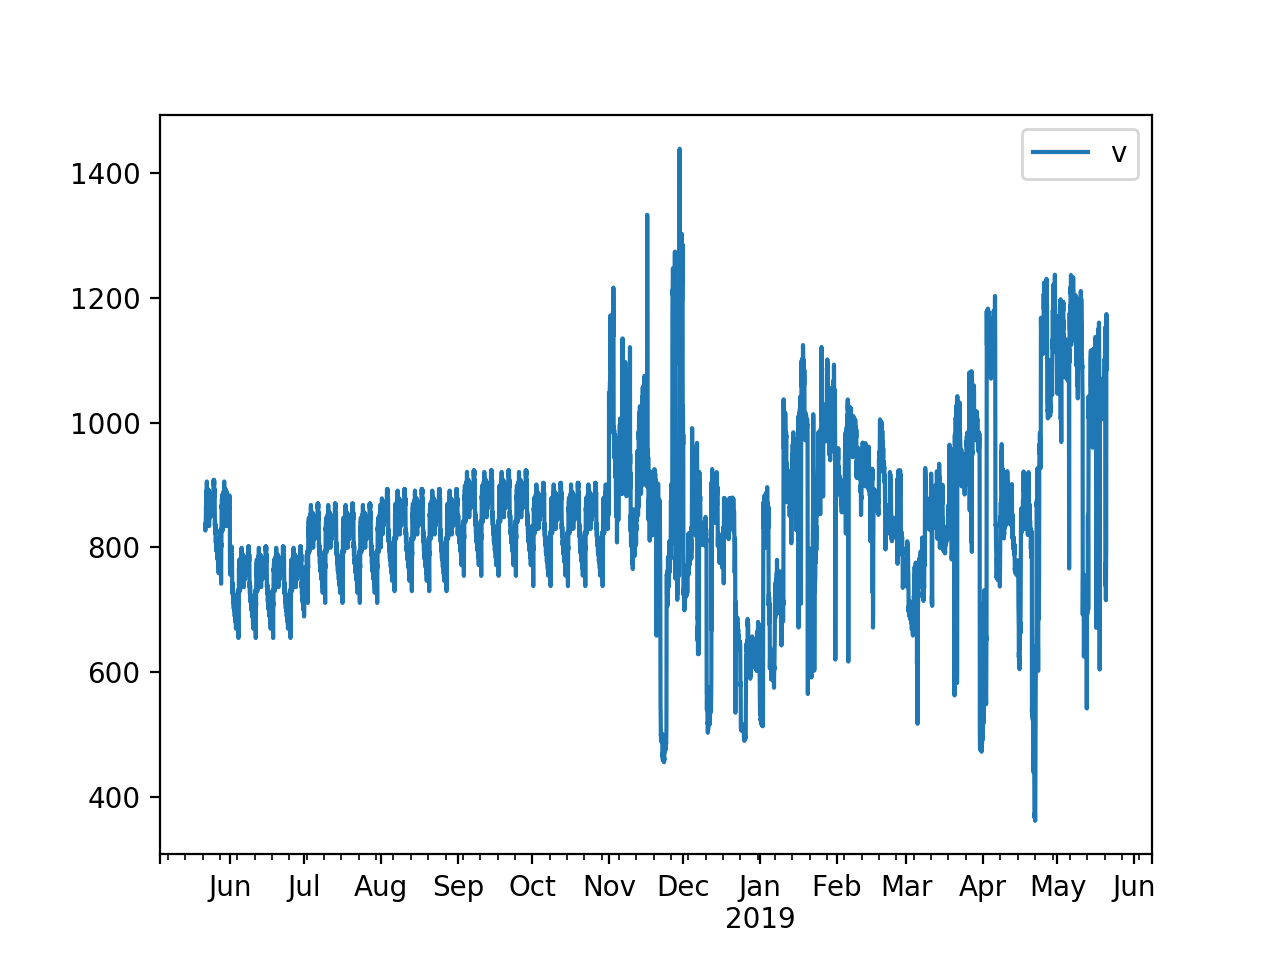

In [56]:
master_cor.plot(y = 'v')

In [111]:
mon_index = master_mon.index.values.tolist()
sca_index = easy_sca.index.values.tolist()
subset = [a in mon_index for a in sca_index]
easy_sca[subset]
easy_sca

,v
m,
4,756720.0
3,624240.0
2,581760.0
1,694080.0
12,188526.0
11,887153.0
10,481680.0
9,542880.0
8,576720.0


<IPython.core.display.Javascript object>


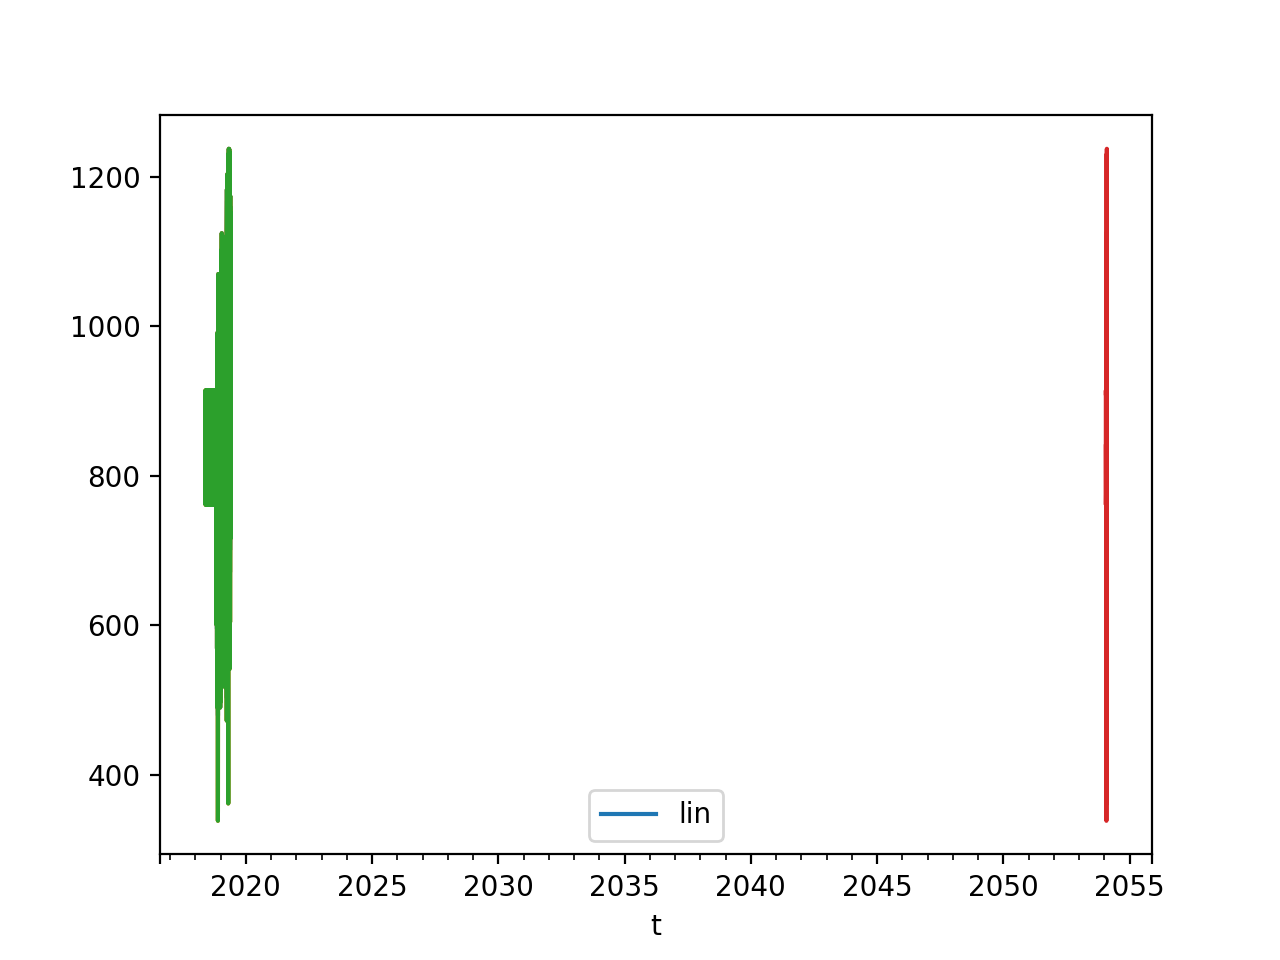

In [29]:
#recent = [yr.year < 2020 for yr in tmp2.index]
tmp2.plot(y = 'lin')

<IPython.core.display.Javascript object>


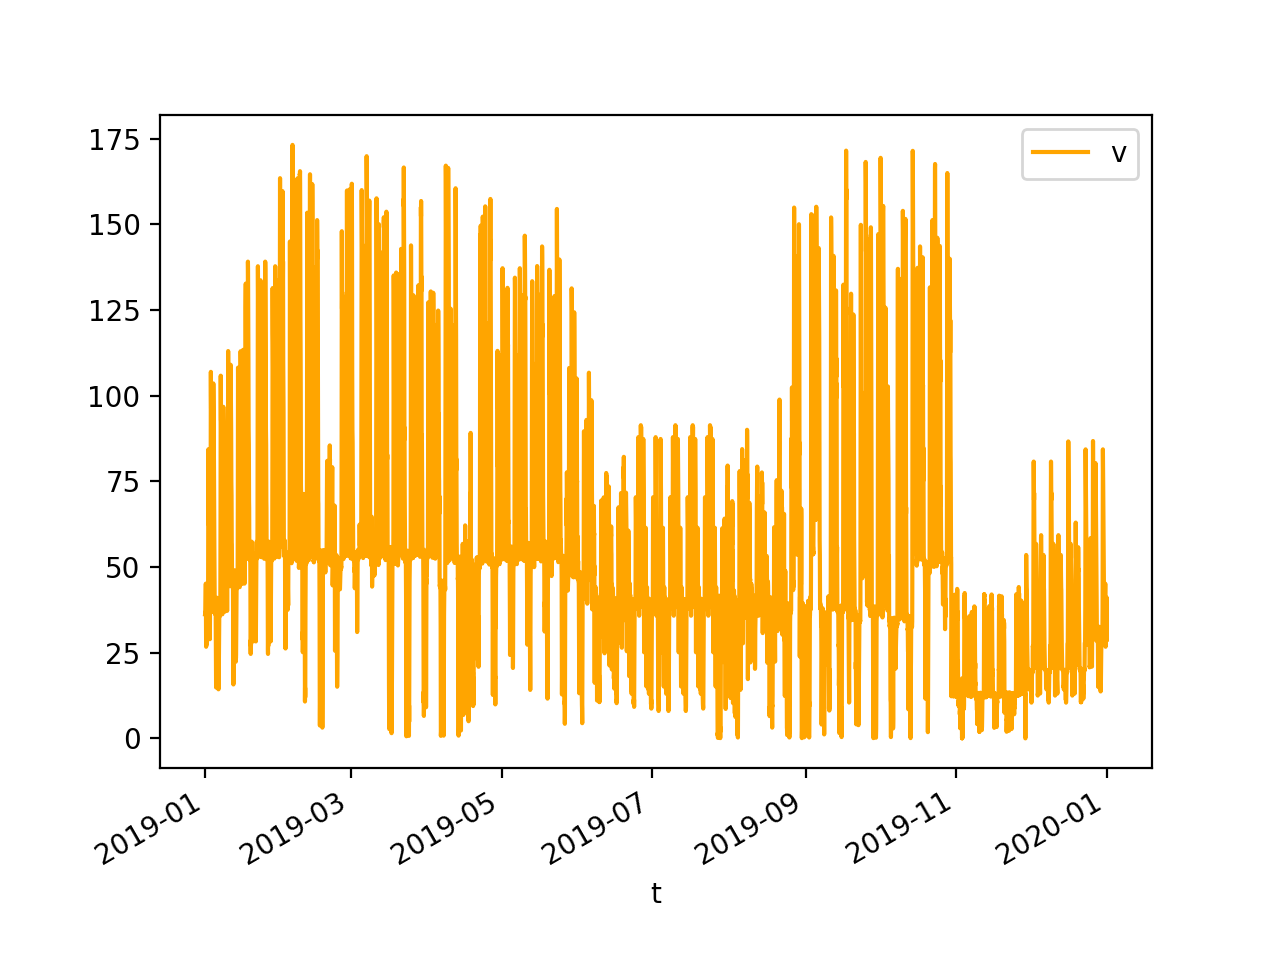

In [19]:
tmp2[recent].plot(y = 'v', color = 'orange')

In [18]:
end_yr = [yr.month > 10 for yr in tmp2.index]
keep = [a and b for a, b in zip(end_yr, tmp2.err)]
tmp2[keep]

,v,d,h,pz,lr,vd,td,gap,rm,mc,crm,crsd,var,spike,dip,dst,err,interp,lin
t,,,,,,,,,,,,,,,,,,,
2019-11-01 00:00:00,12.960,4,0,0.000000,False,0.660,0.25,True,37.333663,-24.373663,1.942695,28.826442,-13.546313,False,False,False,True,NaN,48.775456
2019-11-01 00:15:00,12.420,4,0,0.000000,False,-0.540,0.25,True,37.335997,-24.915997,1.971240,28.823306,-13.639759,False,False,False,True,NaN,48.765025
2019-11-01 00:30:00,12.480,4,0,0.000000,False,0.060,0.25,True,37.338455,-24.858455,1.999898,28.819988,-13.429859,False,False,False,True,NaN,48.754594
2019-11-01 00:45:00,12.300,4,0,0.000000,False,-0.180,0.25,True,37.332038,-25.032038,2.019670,28.820880,-13.394120,False,False,False,True,NaN,48.744162
2019-11-01 01:00:00,12.960,4,1,0.000000,False,0.660,0.25,True,37.286497,-24.326497,2.000306,28.801862,-13.161387,False,False,False,True,NaN,48.733731
2019-11-01 01:15:00,12.180,4,1,0.000000,False,-0.780,0.25,True,37.229372,-25.049372,1.969348,28.762413,-13.719630,False,False,False,True,NaN,48.723300
2019-11-01 01:30:00,12.600,4,1,0.000000,False,0.420,0.25,True,37.160830,-24.560830,1.926965,28.700190,-13.745861,False,False,False,True,NaN,48.712868
2019-11-01 01:45:00,12.960,4,1,0.000000,False,0.360,0.25,True,37.084955,-24.124955,1.877244,28.623598,-13.851260,False,False,False,True,NaN,48.702437
2019-11-01 02:00:00,13.080,4,2,0.000000,False,0.120,0.25,True,37.021622,-23.941622,1.840063,28.578905,-14.011303,False,False,False,True,NaN,48.692006


Series([], Name: lin, dtype: float64)

In [ ]:
#for points where linear interpolation don't work, use likeday estimation
counts = pd.DataFrame(tmp2.groupby([tmp2.d, tmp2.h, tmp2.err])['v'].count())
means = pd.DataFrame(tmp2.groupby([tmp2.d, tmp2.h, tmp2.err])['v'].mean())

means.iloc[means.index.get_level_values('err') == True]
means.iloc[means.index.get_level_values('err') == False]
#pd.merge(tmp, weekly_periodic_reads, how = 'left', right_index = True, left_on = ['d', 'h'])

## Graph

In [ ]:
cols = []
for errors in output.err:
    if errors:
        cols.append('r')
    else:
        cols.append('b')

In [ ]:
output.plot(y = 'v', color = 'cols')

In [ ]:
ewx = parse_ewx(filedf.files[3])
ewx.loc[ewx.index.year <= 2020,:].plot(y = 'v', color = 'orange')